In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pickle as pkl
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

from classo import classo_problem, clr
from tqdm.notebook import tqdm

os.chdir('/container/mount/point/')

In [43]:
def solve_classo_problem(X, y, C, intercept, classification=True, concomitant=False, huber=False,  label=None,
                         lam_fixed=True, cv=True, stabsel_method="first", lam="theoretical", rho=0.5,
                         stabsel_threshold=0.2, numerical_method='Path-Alg', Nsubset=5, seed=42, path=True, Nlam=20):
    """
    Configure and solve the classo_problem.

    Parameters:
    - X: data matrix, usually log-transformed
    - y: target variable
    - C: constaint matrix
    - intercept: Whether to include an intercept in the model
    - classification: Whether to set the problem as a classification problem
    - concomitant: Whether to use concomitant formulation
    - huber: Whether to use Huber loss
    - lam_fixed: Whether to fix lambda in model selection
    - cv: Whether to use cross-validation in model selection
    - stabsel_method: Method for stability selection
    - lam: Lambda setting for LAMfixedparameters
    - stabsel_threshold: Threshold for stability selection
    - numerical_method: Numerical method for PATHparameters

    Returns:
    - Configured and solved problem
    """
    
    # Create the classo problem instance
    problem = classo_problem(X, y, C, label=label)
    
    # Set formulation parameters
    problem.formulation.classification = classification
    problem.formulation.concomitant = concomitant
    problem.formulation.huber = huber
    problem.formulation.intercept = intercept
    if huber:
        problem.formulation.rho_classification = rho ### closer to 1 more like Hinge loss
    
    # Set model selection parameters
    problem.model_selection.CVparameters.seed = seed
    problem.model_selection.LAMfixed = lam_fixed
    problem.model_selection.CV = cv
    problem.model_selection.CVparameters.Nsubset = Nsubset
    
    problem.model_selection.PATHparameters.Nlam = Nlam
    
    problem.model_selection.StabSelparameters.method = stabsel_method
    problem.model_selection.LAMfixedparameters.lam = lam
    problem.model_selection.PATH = path
    problem.model_selection.StabSelparameters.threshold = stabsel_threshold
    problem.model_selection.PATHparameters.numerical_method = numerical_method
    
    # Solve the problem
    problem.solve()

    return problem.solution

In [44]:
def calculate_mcr(beta, X, y):
    """
    Calculate misclassification rate given beta, features X, and true labels y.
    """
    y_hat = np.sign(np.dot(X, beta))
    y_hat[y_hat == 0] = 1  # Treat 0 as +1
    return np.mean(y_hat.flatten() != y)

def compute_metrics(sol, X_test, y_test):
    beta_fix = sol.LAMfixed.beta.reshape(-1, 1)
    mcr_fix = calculate_mcr(beta_fix, X_test, y_test)
    beta_cv = sol.CV.beta.reshape(-1, 1)
    mcr_cv = calculate_mcr(beta_cv, X_test, y_test)
    beta_stable = sol.StabSel.refit.reshape(-1, 1)
    mcr_stable = calculate_mcr(beta_stable, X_test, y_test)
    return mcr_fix, mcr_cv, mcr_stable

In [72]:
seed = 42
CV = True
intercept = True
path=True
huber = False
threshold = 0.1
stabsel_threshold = 0.65
Nlam = 160
num_splits = 5
pseudo_count = 1

class_problem = "C1"


--- Level: class ---


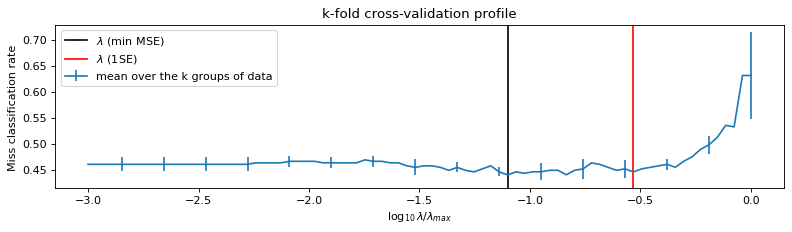

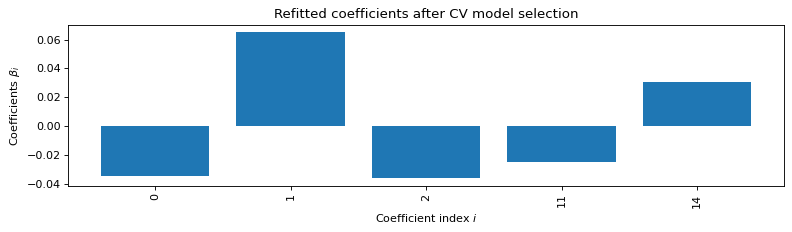

Selected taxonomic names for class (CV): ['c__Actinobacteria;', 'c__Alphaproteobacteria;', 'c__Bacilli;', 'c__Negativicutes;', 'c__Verrucomicrobiae;']
Out-of-sample MCR (LAMfixed): 0.506
Out-of-sample MCR (CV): 0.575
Out-of-sample MCR (StabSel): 0.563
In-sample MCR (LAMfixed): 0.389
In-sample MCR (CV): 0.424
In-sample MCR (StabSel): 0.398

--- Level: order ---


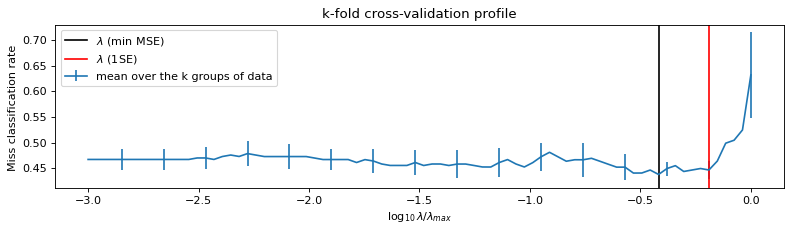

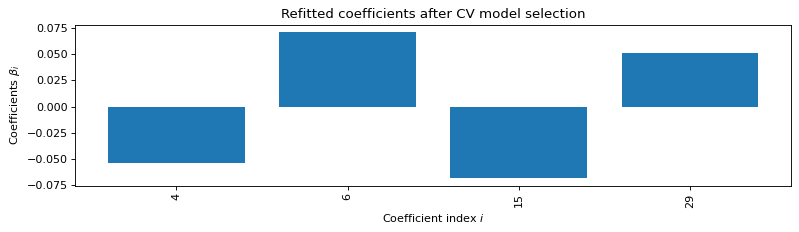

Selected taxonomic names for order (CV): ['o__Bifidobacteriales;', 'o__Christensenellales;', 'o__Erysipelotrichales;', 'o__Rhodospirillales;']
Out-of-sample MCR (LAMfixed): 0.425
Out-of-sample MCR (CV): 0.448
Out-of-sample MCR (StabSel): 0.506
In-sample MCR (LAMfixed): 0.340
In-sample MCR (CV): 0.418
In-sample MCR (StabSel): 0.406

--- Level: family ---


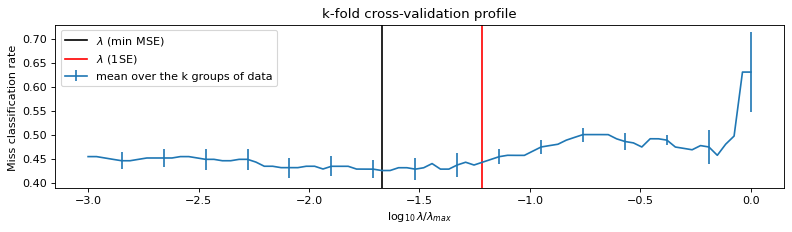

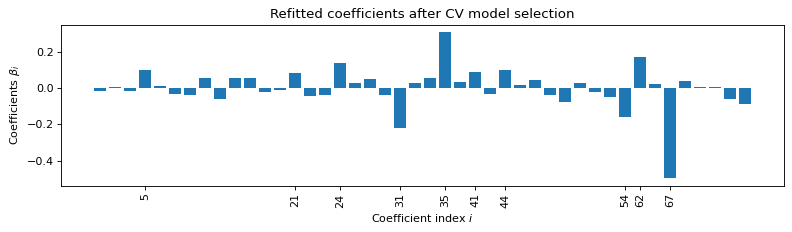

Selected taxonomic names for family (CV): ['f__Acidaminococcaceae;', 'f__Akkermansiaceae;', 'f__Anaerovoracaceae;', 'f__Bacteroidaceae;', 'f__Barnesiellaceae;', 'f__Bifidobacteriaceae;', 'f__Butyricicoccaceae;', 'f__Christensenellaceae;', 'f__Clostridia_UCG-014;', 'f__Clostridia_vadinBB60_group;', 'f__Clostridiaceae;', 'f__Coriobacteriaceae;', 'f__Enterobacteriaceae;', 'f__Enterococcaceae;', 'f__Erysipelatoclostridiaceae;', 'f__Erysipelotrichaceae;', 'f__Flavobacteriaceae;', 'f__Gastranaerophilales;', 'f__Izemoplasmatales;', 'f__Lactobacillaceae;', 'f__Methanobacteriaceae;', 'f__Muribaculaceae;', 'f__Oscillospiraceae;', 'f__Oscillospirales;', 'f__Prevotellaceae;', 'f__Puniceicoccaceae;', 'f__Rikenellaceae;', 'f__Ruminococcaceae;', 'f__Selenomonadaceae;', 'f__Streptococcaceae;', 'f__Sutterellaceae;', 'f__Tannerellaceae;', 'f__UCG-010;', 'f__Veillonellaceae;', 'f__Victivallaceae;', 'f__[Clostridium]_methylpentosum_group;', 'f__unknown_17;', 'f__unknown_2;', 'f__unknown_37;', 'f__unknown_

In [73]:
kora_matched_df = pd.read_csv("data/smoking_KORA_experiment.csv", index_col=0)
asv = pd.read_csv("data/filtered_count_table.csv", index_col=0)
taxonomy_df = pd.read_csv("data/taxonomy_clean.csv", index_col=0)

taxonomy_levels = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'ASV']

# Prepare taxa_dict
taxa_dict = {}
for level in taxonomy_df.columns.difference(['name']):
    taxa_dict[level] = asv.join(taxonomy_df[level]).groupby(level).sum()
taxa_dict['ASV'] = asv

# Ensure kora_matched_df index is string
kora_matched_df.index = kora_matched_df.index.astype(str)
sample_ids = kora_matched_df.index

results = {}

for level in ['class', 'order', 'family']:
    print(f"\n--- Level: {level} ---")
    X = taxa_dict[level]

    X = X.loc[:, X.columns.intersection(sample_ids)]
    X = X.loc[(X != 0).any(axis=1)]
    X = X.T
    X.index = X.index.astype(str)
    common_ids = X.index.intersection(kora_matched_df.index)
    X = X.loc[common_ids]

    # Transform X
    X_array = clr(X.T, pseudo_count)
    X_array = X_array.T

    y_aligned = kora_matched_df.loc[common_ids, 'W'].values
    y_aligned = np.where(y_aligned == 0, -1, 1)


    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_array, y_aligned, test_size=0.2, random_state=42, stratify=y_aligned)

    # Solve problem
    C = np.ones((1, X_train.shape[1]))
    sol = solve_classo_problem(X_train, y_train, C, intercept=True, stabsel_threshold=stabsel_threshold, path=path, huber=huber, Nlam=Nlam)

    results[level] = {"X": X, "y": y_aligned, "solution": sol}

    feature_names = X.columns.tolist()
    selected_indices = [int(i) for i in str(sol.CV).split("Selected variables :")[1].split("Running time")[0].split() if i.isdigit()]
    selected_taxa = [feature_names[i] for i in selected_indices if i < len(feature_names)]
    print(f"Selected taxonomic names for {level} (CV): {selected_taxa}")

    # --- Misclassification rates ---
    # Out-of-sample
    # Add intercept column to X_test for prediction if needed
    if sol.LAMfixed.beta.shape[0] == X_test.shape[1] + 1:
        X_test_pred = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
        X_train_pred = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    else:
        X_test_pred = X_test
        X_train_pred = X_train

    mcr_fix, mcr_cv, mcr_stable = compute_metrics(sol, X_test_pred, y_test)
    print(f"Out-of-sample MCR (LAMfixed): {mcr_fix:.3f}")
    print(f"Out-of-sample MCR (CV): {mcr_cv:.3f}")
    print(f"Out-of-sample MCR (StabSel): {mcr_stable:.3f}")

    # In-sample
    mcr_fix_in, mcr_cv_in, mcr_stable_in = compute_metrics(sol, X_train_pred, y_train)
    print(f"In-sample MCR (LAMfixed): {mcr_fix_in:.3f}")
    print(f"In-sample MCR (CV): {mcr_cv_in:.3f}")
    print(f"In-sample MCR (StabSel): {mcr_stable_in:.3f}")

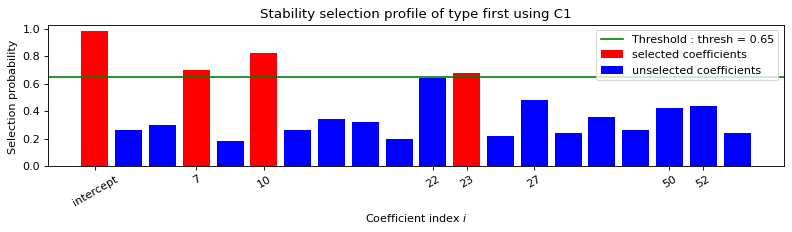

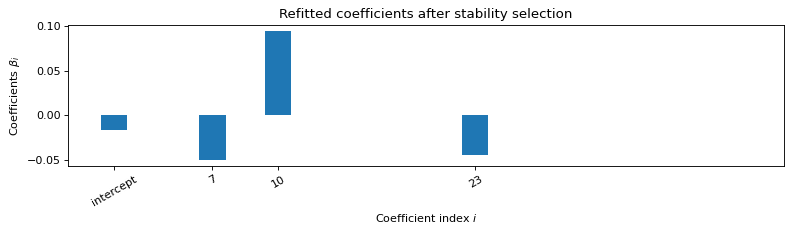

Selected taxonomic names for family (StabSel): ['f__Bifidobacteriaceae;', 'f__Christensenellaceae;', 'f__Erysipelotrichaceae;']


In [75]:
level = 'family'

sol_family = results[level]['solution'].__dict__['StabSel']
X = results[level]['X']

feature_names = X.columns.tolist()
selected_indices = [int(i) for i in str(sol_family).split("Selected variables :")[1].split("Running time")[0].split() if i.isdigit()]
selected_taxa = [feature_names[i] for i in selected_indices if i < len(feature_names)]
print(f"Selected taxonomic names for {level} (StabSel): {selected_taxa}")